# 03: Offshore Wind Simulation Analysis

In [ ]:
# ============================
# CELL 1 — LOAD STAGE 2 CURTAILMENT MODEL
# ============================

import pandas as pd
import numpy as np

stage2_model = pd.read_csv(
    "stage2_curtailment_model_2025.csv",
    parse_dates=["DateTime"],
    index_col="DateTime"
).copy()

# ============================
# SPATIAL LAYER — EAST COAST OFFSHORE INJECTION HUBS
# ============================

substations_df = pd.read_csv("csv_nodes.csv")

# 1. Substations only (exclude plants)
subs = substations_df[
    substations_df["type"] == "substation"
].copy()

# 2. Transmission backbone only (220kV+)
ehv = subs[
    subs["voltage"] >= 220000
].copy()

# 3. East Coast transmission corridor
east_corridor = ehv[
    (ehv["longitude"] > -6.5) &
    (ehv["longitude"] < -5.8) &
    (ehv["latitude"] > 52.2) &
    (ehv["latitude"] < 53.8)
].copy()

exclude_keywords = [
    "GIS",
    "Inchicore",
    "Finglas",
    "Corduff",
    "Turlough"
]

east_corridor = east_corridor[
    ~east_corridor["name"].str.contains(
        "|".join(exclude_keywords),
        case=False,
        na=False
    )
]

east_corridor["site_key"] = (
    east_corridor["name"]
    .str.replace(" Substation", "", regex=False)
    .str.replace(" Transmission", "", regex=False)
    .str.replace(" Conversion", "", regex=False)
    .str.strip()
)

east_corridor = (
    east_corridor
    .sort_values(by="voltage", ascending=False)
    .drop_duplicates(subset="site_key")
    .drop(columns=["site_key"])
)

# Final offshore injection hubs (no artificial cap)
injection_hubs = east_corridor.copy()

# ============================
# THERMAL LIMIT ASSUMPTIONS
# ============================

def assign_limit(voltage):
    if voltage >= 400000:
        return 1000.0   # 400kV backbone intake
    elif voltage >= 220000:
        return 500.0    # 220kV intake assumption
    else:
        return 0.0

injection_hubs["thermal_limit_mw"] = (
    injection_hubs["voltage"].apply(assign_limit)
)

num_hubs = len(injection_hubs)
total_capacity = injection_hubs["thermal_limit_mw"].sum()

print(f"Injection Hubs Identified: {num_hubs}")
print(f"Total Intake Capacity: {total_capacity:.1f} MW")
print(injection_hubs[["name", "voltage", "thermal_limit_mw"]])


Injection Hubs Identified: 3
Total Intake Capacity: 1500.0 MW
                           name  voltage  thermal_limit_mw
5       Arklow 220kV Substation   220000             500.0
32      Carrickmines Substation   220000             500.0
209  Stepaside 220kV Substation   220000             500.0


In [ ]:
# ============================
# CELL 2 — LOAD OFFSHORE WIND DATA (RAW, CORRECTED)
# ============================

def load_offshore_aggregated(path):
    """
    Loads offshore aggregated datasets where the first column is time
    but has no header.
    """
    df = pd.read_csv(path)

    # Assume first column is time
    time_col = df.columns[0]

    df[time_col] = pd.to_datetime(df[time_col], dayfirst=True)
    df = df.set_index(time_col).sort_index()
    
    if df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    else:
        df.index = df.index.tz_convert('UTC')

    return df


# Aggregated offshore power output (MW)
offshore_power = load_offshore_aggregated(
    "Offshore_Wind_Farms_Generation/All_Power_Data.csv"
)

# Aggregated offshore windspeed
offshore_wind = load_offshore_aggregated(
    "Offshore_Wind_Farms_Generation/All_Windspeed_Data.csv"
)

print("Offshore power data (Time-Aligned):")
print(offshore_power.shape)
display(offshore_power.head())

print("\nOffshore windspeed data (Time-Aligned):")
print(offshore_wind.shape)
display(offshore_wind.head())

print("\nPower TZ:", offshore_power.index.tz)
print("Wind TZ:", offshore_wind.index.tz)

Offshore power data (Time-Aligned):
(350640, 30)


,London_Array,Greater_Gabbard,Gwynt_y_Mor,Gode_Wind,Gemini,Race_Bank,Walney,Borkum_Riffgrund,Hohe_See,Horns_Rev,...,Iles_dYeu_et_de_Noirmoutir,Baie_de_Saint_Brieuc,Hautes_Falaises,Hollandse_Kust_Zuid,Hollandse_Kust_Noord,Baltic_Eagle,Seagreen,Dieppe_et_Le_Treport,"Dogger_Bank_(Phase_A,B)",Total_Power
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,353.45444,293.80670,6.140144,140.163970,600.0,505.73566,21.800404,594.82227,187.20795,56.143580,...,41.463924,0.000000,23.291782,1540.0000,759.00000,230.56738,836.69360,94.366646,2470.0000,15910.84201
1970-01-01 00:00:00.000000001+00:00,299.53574,248.45470,7.909159,115.589165,600.0,460.88232,30.747032,509.18414,193.68411,32.906456,...,86.561510,1.211870,10.722403,1512.3055,759.00000,170.35165,814.83560,62.916740,2470.0000,15158.12692
1970-01-01 00:00:00.000000002+00:00,272.68637,237.68678,7.549715,93.657880,600.0,449.02432,25.194609,495.55426,237.19164,7.589672,...,133.902950,1.499034,8.039917,1422.8864,750.93040,143.86520,822.23710,49.379795,2466.9678,14724.95321
1970-01-01 00:00:00.000000003+00:00,284.21000,236.33168,0.000000,77.971664,600.0,476.89220,21.784980,551.01794,386.91476,0.000000,...,113.082440,0.268441,4.257623,1317.5120,696.06464,130.49031,866.95935,32.897152,2470.0000,14714.61997
1970-01-01 00:00:00.000000004+00:00,314.02870,251.21896,0.000000,100.388790,600.0,488.31824,13.490430,717.99207,485.76926,0.000000,...,68.284680,1.346184,4.946065,1245.5037,628.56256,134.19700,914.77740,23.800713,2470.0000,15048.23576



Offshore windspeed data (Time-Aligned):
(350640, 29)


,London_Array,Greater_Gabbard,Gwynt_y_Mor,Gode_Wind,Gemini,Race_Bank,Walney,Borkum_Riffgrund,Hohe_See,Horns_Rev,...,Moray_Firth,Iles_dYeu_et_de_Noirmoutir,Baie_de_Saint_Brieuc,Hautes_Falaises,Hollandse_Kust_Zuid,Hollandse_Kust_Noord,Baltic_Eagle,Seagreen,Dieppe_et_Le_Treport,"Dogger_Bank_(Phase_A,B)"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00+00:00,8.897490,10.010520,3.727226,7.466906,11.920606,11.833993,4.151103,10.069755,8.287906,5.198418,...,10.388420,5.108845,2.681382,4.435593,13.401993,14.699871,8.988275,11.140968,6.276498,12.883967
1970-01-01 00:00:00.000000001+00:00,8.496386,9.560132,3.854810,6.991063,11.360207,11.467006,4.466284,9.401815,8.380801,4.616362,...,10.522754,6.127016,3.163945,3.808973,12.405228,13.551462,8.123134,10.990085,5.634106,12.620873
1970-01-01 00:00:00.000000002+00:00,8.308637,9.374216,3.829896,6.509530,11.575466,11.365966,4.276385,9.299107,8.970838,3.670934,...,10.395267,6.965517,3.202919,3.640124,11.671988,12.553720,7.690540,11.040682,5.314363,12.382963
1970-01-01 00:00:00.000000003+00:00,8.388339,9.356504,3.082338,6.121297,12.431805,11.600667,4.150515,9.721397,10.932331,2.681026,...,10.357217,6.615068,2.977136,3.363533,11.082034,11.605343,7.454055,11.358382,4.865003,12.750606
1970-01-01 00:00:00.000000004+00:00,8.600841,9.586025,2.291918,6.664081,13.136039,11.694211,3.804637,11.299594,12.797743,2.537675,...,10.704205,5.752271,3.182696,3.418193,10.737633,10.876567,7.520968,11.730346,4.571076,13.695108



Power TZ: UTC
Wind TZ: UTC


In [ ]:
# ============================
# CELL 3A — OFFSHORE CAPACITY FACTOR (HISTORICAL)
# ============================

# Robust installed capacity proxy
installed_capacity_mw = offshore_power["Total_Power"].quantile(0.995)

offshore_cf_series = (
    offshore_power["Total_Power"] / installed_capacity_mw
).clip(0.0, 1.0)

# Correct windspeed aggregation (mean)
offshore_ws_series = (
    offshore_wind
    .select_dtypes(include=[np.number])
    .mean(axis=1)
)

print("Offshore CF historical summary:")
display(offshore_cf_series.describe())

print("\nOffshore Mean Windspeed summary:")
display(offshore_ws_series.describe())


# ============================
# CELL 3B — OFFSHORE CF REPLAY (SIMULATION INPUT)
# ============================

cf_values = offshore_cf_series.values
ws_values = offshore_ws_series.values

repeats = int(np.ceil(len(stage2_model) / len(cf_values)))

offshore_cf_sim = np.tile(cf_values, repeats)[:len(stage2_model)]
offshore_ws_sim = np.tile(ws_values, repeats)[:len(stage2_model)]

stage2_model["Offshore_CF"] = offshore_cf_sim
stage2_model["Offshore_Windspeed_Avg"] = offshore_ws_sim

print("\nSimulated offshore CF & Windspeed applied to Stage 4 timeline.")
display(stage2_model[["Offshore_CF", "Offshore_Windspeed_Avg"]].head())


Offshore CF historical summary:


count    350640.000000
mean          0.535484
std           0.274793
min           0.001432
25%           0.295729
50%           0.523105
75%           0.782704
max           1.000000
Name: Total_Power, dtype: float64


Offshore Mean Windspeed summary:


count    350640.000000
mean          9.255148
std           3.315986
min           1.962671
25%           6.752544
50%           8.713765
75%          11.245328
max          26.071397
dtype: float64


Simulated offshore CF & Windspeed applied to Stage 4 timeline.


,Offshore_CF,Offshore_Windspeed_Avg
DateTime,,
2025-01-01 00:00:00+00:00,0.693293,9.391960
2025-01-01 00:00:00+00:00,0.660494,9.039429
2025-01-01 00:00:00+00:00,0.641620,8.846185
2025-01-01 00:00:00+00:00,0.641169,8.789432
2025-01-01 00:30:00+00:00,0.655706,8.950302


In [4]:
# ============================
# CELL 4 — OFFSHORE WIND SCENARIO SCALING & INJECTION
# ============================

offshore_capacity_scenarios = {
    "Offshore_0p5GW": 0.5,
    "Offshore_1GW": 1.0,
    "Offshore_5GW": 5.0,
}

scenario_systems = {}

# Precompute total intake capacity
total_intake_capacity = injection_hubs["thermal_limit_mw"].sum()

for scenario_name, capacity_gw in offshore_capacity_scenarios.items():

    df = stage2_model.copy()

    capacity_mw = capacity_gw * 1000

    # 1. Offshore raw generation
    df["Offshore_MW"] = df["Offshore_CF"] * capacity_mw

    # 2. Apply structural intake constraint
    df["Offshore_Accepted_MW"] = np.minimum(
        df["Offshore_MW"],
        total_intake_capacity
    )

    # 3. Structural node waste (thermal congestion)
    df["Node_Waste_MW"] = (
        df["Offshore_MW"] - df["Offshore_Accepted_MW"]
    )

    # 4. Updated total wind
    df["Total_Wind_MW"] = (
        df["AI Wind Generation"] +
        df["Offshore_Accepted_MW"]
    )

    # 5. SNSP update (non-synchronous)
    df["SNSP_with_Offshore"] = (
        (df["Total_Wind_MW"] + df["AI Solar Generation"])
        / df["AI Demand"]
    )

    # 6. Thermal overload indicator
    df["Node_Thermal_Overload_Risk"] = (
        df["Offshore_MW"] > total_intake_capacity
    ).astype(int)

    scenario_systems[scenario_name] = df

    print(f"{scenario_name} injected:")
    print(f"  Offshore capacity:      {capacity_gw} GW")
    print(f"  Mean offshore MW:       {df['Offshore_MW'].mean():.1f}")
    print(f"  Mean accepted MW:       {df['Offshore_Accepted_MW'].mean():.1f}")
    print(f"  Total node waste (avg): {df['Node_Waste_MW'].mean():.1f}")
    print(f"  Thermal bind events:    {df['Node_Thermal_Overload_Risk'].sum()}")
    print("")

print("Scenario injection complete.")


Offshore_0p5GW injected:
  Offshore capacity:      0.5 GW
  Mean offshore MW:       267.6
  Mean accepted MW:       267.6
  Total node waste (avg): 0.0
  Thermal bind events:    0

Offshore_1GW injected:
  Offshore capacity:      1.0 GW
  Mean offshore MW:       535.3
  Mean accepted MW:       535.3
  Total node waste (avg): 0.0
  Thermal bind events:    0

Offshore_5GW injected:
  Offshore capacity:      5.0 GW
  Mean offshore MW:       2676.3
  Mean accepted MW:       1355.4
  Total node waste (avg): 1320.9
  Thermal bind events:    52283

Scenario injection complete.


In [ ]:
# ============================
# CELL 5 — CONSTRAINT RE-EVALUATION & ENERGY ROUTING
# ============================

SNSP_LIMIT = 0.75
scenario_results = {}

for scenario_name, df in scenario_systems.items():

    sim = df.copy()

    # ---------------------------
    # 1. Structural Intake Constraint (already applied)
    # ---------------------------
    sim = sim[~sim.index.duplicated(keep="first")]

    sim["Local_Node_Excess_MW"] = sim["Node_Waste_MW"]

    # ---------------------------
    # 2. Export Headroom
    # ---------------------------
    sim["Exportable_MW"] = (-sim["Total IC Flow"]).clip(lower=0.0)

    # Only accepted energy can be exported
    sim["Offshore_Exported_MW"] = np.minimum(
        sim["Offshore_Accepted_MW"],
        sim["Exportable_MW"]
    )

    # Remaining offshore after export
    sim["Offshore_Remaining_MW"] = (
        sim["Offshore_Accepted_MW"] -
        sim["Offshore_Exported_MW"]
    )

    # ---------------------------
    # 3. SNSP Constraint
    # ---------------------------
    sim["Max_NonSync_MW"] = SNSP_LIMIT * sim["AI Demand"]

    non_sync_total = (
        sim["Total_Wind_MW"] +
        sim["AI Solar Generation"]
    )

    sim["SNSP_BINDING"] = non_sync_total > sim["Max_NonSync_MW"]

    sim["Excess_NonSync_MW"] = (
        non_sync_total -
        sim["Max_NonSync_MW"]
    ).clip(lower=0.0)

    # Curtail only from remaining offshore
    sim["System_Curtailed_MW"] = np.minimum(
        sim["Offshore_Remaining_MW"],
        sim["Excess_NonSync_MW"]
    )

    # ---------------------------
    # 4. Final Accounting
    # ---------------------------
    sim["Offshore_Curtailed_MW"] = (
        sim["Local_Node_Excess_MW"] +
        sim["System_Curtailed_MW"]
    )

    sim["Offshore_Consumed_MW"] = (
        sim["Offshore_MW"]
        - sim["Offshore_Curtailed_MW"]
        - sim["Offshore_Exported_MW"]
    ).clip(lower=0.0)

    scenario_results[scenario_name] = sim

    print(f"{scenario_name} Evaluation:")
    print(f"  Mean Curtailed MW: {sim['Offshore_Curtailed_MW'].mean():.1f}")
    print(f"  Mean Node Waste:   {sim['Local_Node_Excess_MW'].mean():.1f}")
    print(f"  SNSP Bind Hours:   {sim['SNSP_BINDING'].sum()}")
    print("-" * 30)

print("Constraint re-evaluation complete.")


Offshore_0p5GW Evaluation:
  Mean Curtailed MW: 12.2
  Mean Node Waste:   0.0
  SNSP Bind Hours:   1625
------------------------------
Offshore_1GW Evaluation:
  Mean Curtailed MW: 46.7
  Mean Node Waste:   0.0
  SNSP Bind Hours:   2568
------------------------------
Offshore_5GW Evaluation:
  Mean Curtailed MW: 1558.5
  Mean Node Waste:   1319.6
  SNSP Bind Hours:   5904
------------------------------
Constraint re-evaluation complete.


In [ ]:
results_summary = []

for scenario_name, sim in scenario_results.items():

    sim = sim[~sim.index.duplicated(keep="first")]
    dt_hours = (
        sim.index.to_series()
        .diff()
        .dt.total_seconds()
        .dropna()
        .median() / 3600
    )

    # --- Energy totals (GWh) ---
    consumed_gwh  = sim["Offshore_Consumed_MW"].sum() * dt_hours / 1000
    exported_gwh  = sim["Offshore_Exported_MW"].sum() * dt_hours / 1000
    curtailed_gwh = sim["Offshore_Curtailed_MW"].sum() * dt_hours / 1000

    total_gwh = consumed_gwh + exported_gwh + curtailed_gwh

    if total_gwh > 0:
        consumed_pct  = consumed_gwh  / total_gwh * 100
        exported_pct  = exported_gwh  / total_gwh * 100
        curtailed_pct = curtailed_gwh / total_gwh * 100
    else:
        consumed_pct = exported_pct = curtailed_pct = 0.0

    zero_value_hours = (
        (sim["Offshore_Consumed_MW"] == 0) &
        (sim["Offshore_Exported_MW"] == 0) &
        (sim["Offshore_MW"] > 0)
    ).sum() * dt_hours

    snsp_binding_hours = sim["SNSP_BINDING"].sum() * dt_hours

    results_summary.append({
        "Scenario": scenario_name,
        "Consumed_GWh": consumed_gwh,
        "Exported_GWh": exported_gwh,
        "Curtailed_GWh": curtailed_gwh,
        "Consumed_%": consumed_pct,
        "Exported_%": exported_pct,
        "Curtailed_%": curtailed_pct,
        "Zero_Value_Hours": zero_value_hours,
        "SNSP_Binding_Hours": snsp_binding_hours,
    })

results_df = pd.DataFrame(results_summary)
display(results_df.round(2))

print(len(sim) * dt_hours)


,Scenario,Consumed_GWh,Exported_GWh,Curtailed_GWh,Consumed_%,Exported_%,Curtailed_%,Zero_Value_Hours,SNSP_Binding_Hours
0,Offshore_0p5GW,2101.54,134.13,107.26,89.7,5.72,4.58,17.5,812.5
1,Offshore_1GW,4104.82,171.66,409.38,87.6,3.66,8.74,17.5,1284.0
2,Offshore_5GW,9583.10,195.49,13650.72,40.9,0.83,58.26,17.5,2952.0


8759.0


In [7]:
print(len(sim)*dt_hours)

8759.0


In [8]:
print(sim.index.dtype)
print(sim.index.is_monotonic_increasing)
print(sim.index.duplicated().sum())
print(sim.index.to_series().diff().value_counts().head())


datetime64[ns, UTC]
True
0
DateTime
0 days 00:30:00    17516
0 days 01:30:00        1
Name: count, dtype: int64


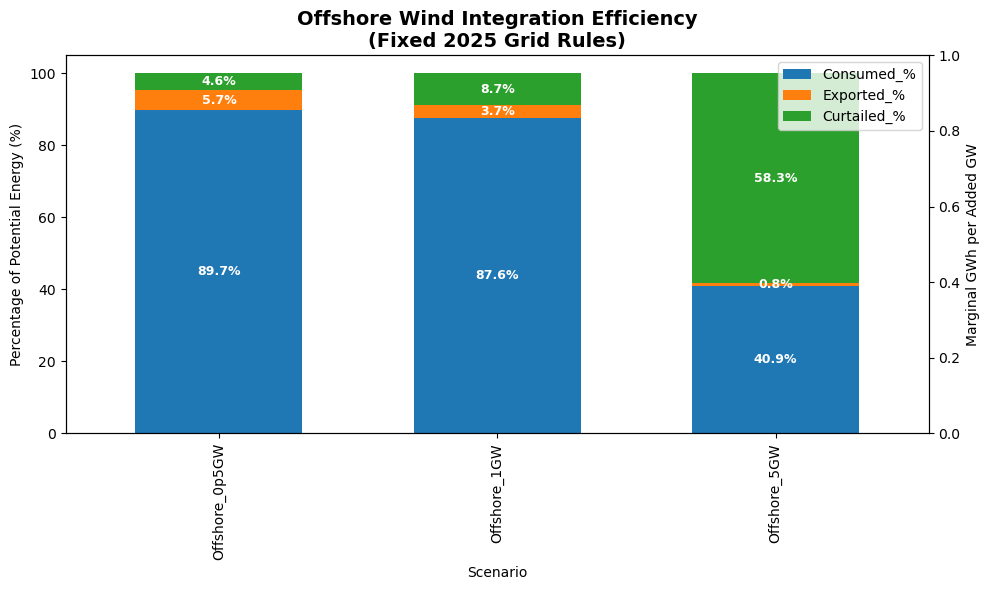

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

results_df["Capacity_GW"] = (
    results_df["Scenario"]
    .str.extract(r'(\d+p?\d*)')[0]
    .str.replace("p", ".")
    .astype(float)
)

results_df = results_df.sort_values("Capacity_GW")

results_df["Marginal_Consumed_GWh_per_GW"] = (
    results_df["Consumed_GWh"].diff() /
    results_df["Capacity_GW"].diff()
)

plot_df = results_df.set_index("Scenario")

x = np.arange(len(plot_df))

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = plot_df[["Consumed_%", "Exported_%", "Curtailed_%"]].plot(
    kind="bar",
    stacked=True,
    ax=ax1,
    width=0.6
)

for container in ax1.containers:
    labels = [f"{v:.1f}%" if v > 0 else "" for v in container.datavalues]
    ax1.bar_label(
        container,
        labels=labels,
        label_type="center",
        color="white",
        fontsize=9,
        fontweight="bold"
    )

ax1.set_ylabel("Percentage of Potential Energy (%)")
ax1.set_title(
    "Offshore Wind Integration Efficiency\n(Fixed 2025 Grid Rules)",
    fontsize=14,
    fontweight="bold"
)

# Secondary axis
ax2 = ax1.twinx()

ax2.set_ylabel("Marginal GWh per Added GW")

ax1.set_xticks(x)
ax1.set_xticklabels(plot_df.index)

plt.tight_layout()
plt.show()


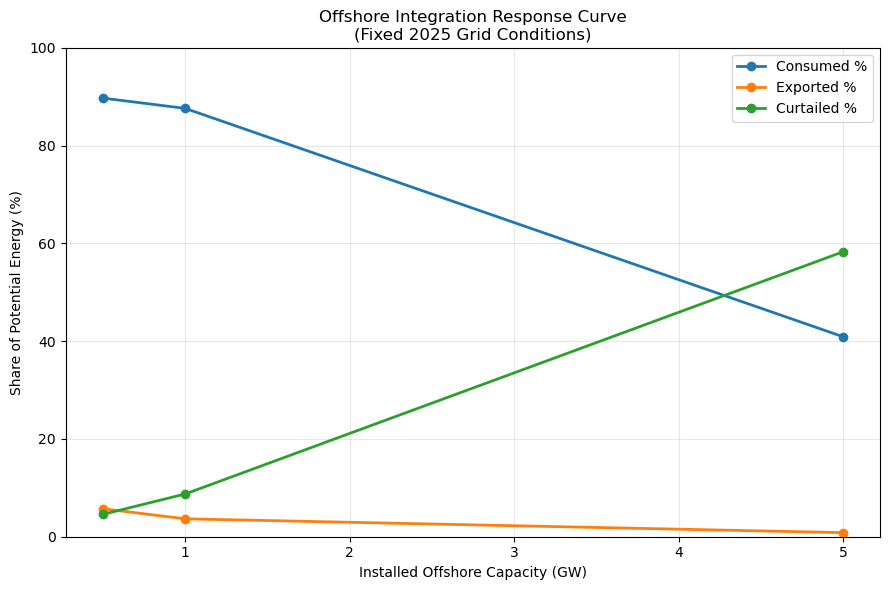

In [17]:
import matplotlib.pyplot as plt

df = results_df.sort_values("Capacity_GW")

plt.figure(figsize=(9, 6))

plt.plot(
    df["Capacity_GW"],
    df["Consumed_%"],
    marker="o",
    linewidth=2,
    label="Consumed %"
)

plt.plot(
    df["Capacity_GW"],
    df["Exported_%"],
    marker="o",
    linewidth=2,
    label="Exported %"
)

plt.plot(
    df["Capacity_GW"],
    df["Curtailed_%"],
    marker="o",
    linewidth=2,
    label="Curtailed %"
)

plt.xlabel("Installed Offshore Capacity (GW)")
plt.ylabel("Share of Potential Energy (%)")
plt.title("Offshore Integration Response Curve\n(Fixed 2025 Grid Conditions)")

plt.ylim(0, 100)
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
# ============================
# FINAL CELL — EXPORT STAGE 3 RESULTS
# ============================

export_frames = []

for scenario_name, sim in scenario_results.items():

    df = sim.copy()

    df["Scenario"] = scenario_name

    df_export = df[[
        "Scenario",
        "Offshore_MW",
        "Offshore_Accepted_MW",
        "Node_Waste_MW",
        "Offshore_Consumed_MW",
        "Offshore_Exported_MW",
        "Offshore_Curtailed_MW",
        "SNSP_BINDING",
        "AI Demand",
        "AI Wind Generation",
        "AI Solar Generation",
        "Total IC Flow"
    ]]

    export_frames.append(df_export)

stage3_offshore_simulation = pd.concat(export_frames)

stage3_offshore_simulation = (
    stage3_offshore_simulation
    .sort_index()
)

stage3_offshore_simulation.to_csv(
    "stage3_offshore_simulation_results.csv",
    index=True
)

print("Stage 3 offshore simulation exported.")
print(stage3_offshore_simulation.shape)
display(stage3_offshore_simulation.head())


Stage 3 offshore simulation exported.
(52554, 12)


,Scenario,Offshore_MW,Offshore_Accepted_MW,Node_Waste_MW,Offshore_Consumed_MW,Offshore_Exported_MW,Offshore_Curtailed_MW,SNSP_BINDING,AI Demand,AI Wind Generation,AI Solar Generation,Total IC Flow
DateTime,,,,,,,,,,,,
2025-01-01 00:00:00+00:00,Offshore_0p5GW,346.646488,346.646488,0.000000,346.646488,0.0,0.000000,False,4061.751,2007.110,0.0,678.876
2025-01-01 00:00:00+00:00,Offshore_1GW,693.292976,693.292976,0.000000,693.292976,0.0,0.000000,False,4061.751,2007.110,0.0,678.876
2025-01-01 00:00:00+00:00,Offshore_5GW,3466.464878,1500.000000,1966.464878,1039.203250,0.0,2427.261628,True,4061.751,2007.110,0.0,678.876
2025-01-01 00:30:00+00:00,Offshore_0p5GW,327.853050,327.853050,0.000000,327.853050,0.0,0.000000,False,3971.138,2204.246,0.0,397.423
2025-01-01 00:30:00+00:00,Offshore_1GW,655.706099,655.706099,0.000000,655.706099,0.0,0.000000,False,3971.138,2204.246,0.0,397.423
